In [1]:
import midynet
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import json

from midynet.util import display
from functools import partial

In [31]:
def SISSusceptibility(x):
    n = x.sum(-1)
    return (np.mean(n**2) - np.mean(n)**2) / np.mean(n)

def SISAverage(x):
    return x.mean()

def GlauberSusceptibility(x):
    x[x == 0] = -1
    m = x.mean(-1)
    return (np.mean(m**2) - np.mean(np.abs(m))**2) / (np.mean(np.abs(m)))

def GlauberAverage(x):
    y = x * 1
    y[x == 0] = -1
    X = np.mean(y, -1)
    return np.mean(np.abs(X))

def CowanSusceptibility(x):
#     x[x == 0] = -1
#     m = x.mean(-1)
#     return (np.mean(m**2) - np.mean(np.abs(m))**2)
    return x.mean()


susceptiblityFunctions = {
    "glauber": GlauberSusceptibility,
    "ising": GlauberSusceptibility,
    "cowan": CowanSusceptibility,
    "sis": SISSusceptibility
}

averageFunctions = {
    "glauber": GlauberAverage,
    "ising": GlauberAverage,
    "sis": SISAverage,
    "cowan": SISAverage,
}


def collect(cfg, seed=None):
    if seed is not None:
        midynet.utility.seed(seed)
    suscFunc = susceptiblityFunctions[cfg.dynamics.name]
    avgFunc = averageFunctions[cfg.dynamics.name]
    graph = midynet.config.RandomGraphFactory.build(cfg.graph)
    dynamics = midynet.config.DynamicsFactory.build(cfg.dynamics)
    dynamics.set_random_graph(graph.get_wrap())
    dynamics.sample()
    x = np.array(dynamics.get_past_states())
    return suscFunc(x), avgFunc(x)
    
    
def searchThresholds(cfg, paramName, paramMin, paramMax, numPoints=10, delta=1, tol=1e-3, numSamples=10, verbose=1):
    diff = np.inf

    history = {"thresholds":[], "susceptibility":{}, "averages":{}}
    while(diff > tol):
        susceptibility = []
        averages = []
        diff = (paramMax - paramMin) / numPoints
        paramScan = np.linspace(paramMin, paramMax, numPoints)
        if verbose > 0:
            print(f"Scaning params {paramScan}")
            print(f"Current diff: {diff}")
        for p in paramScan:
            cfg.dynamics.set_value(paramName, p)
            if verbose == 1:
                print(p)
            with mp.Pool(4) as pool:
                f = partial(collect, cfg)
                seeds = int(time.time()) + np.arange(numSamples).astype("int")
                out = pool.map(f, seeds)
                s = [ss for ss, aa in out]
                a = [aa for ss, aa in out]
            susceptibility.append(np.mean(s))
            averages.append(np.mean(a))
    
        for s, a, p in zip(susceptibility, averages, paramScan):
            if p in history["susceptibility"]:
                history["susceptibility"][p].append(s)
            else:
                history["susceptibility"][p] = [s]
            if p in history["averages"]:
                history["averages"][p].append(a)
            else:
                history["averages"][p] = [a]
                
#         plt.plot(paramScan, susceptibility)
#         plt.show()

        maxIndex = np.argmax(susceptibility)
        paramMin = paramScan[maxIndex] - delta * diff
        paramMax = paramScan[maxIndex] + delta * diff
        history["thresholds"].append(paramScan[maxIndex])
        if verbose > 0:
            print(f"Current history: {history}")
    return history


def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return (ret[n - 1:] / n)[::n]

def collectCowan(cfg, seed=None):
    if seed is not None:
        midynet.utility.seed(seed)
    graph = midynet.config.RandomGraphFactory.build(cfg.graph)
    dynamics = midynet.config.DynamicsFactory.build(cfg.dynamics)
    dynamics.set_random_graph(graph.get_wrap())

    dynamics.sample()
    x = np.array(dynamics.get_past_states())
    return np.mean(x)

def searchCowanThresholds(cfg, paramMin, paramMax, *, delta=2, tol=0.01, numSamples=10, numPoints=10, numProcs=4, verbose=0, parallel=True):
    diff = np.inf
    history = {"thresholds":[], "susceptibility": {}, "averages": {}}
    while(diff > tol):
        avgx = []
        susceptibility = []
        paramScan = np.linspace(paramMin, paramMax, numPoints)
        diff = (paramMax - paramMin) / numPoints
        
        if verbose > 0:
            print(f"Scanning params: {paramScan}")
            print(f"Current diff: {diff}")
        for p in paramScan:
            cfg.dynamics.set_coupling(p)
            f = partial(collectCowan, cfg)
            seeds = int(time.time()) + np.arange(numSamples).astype("int")
            if parallel:
                with mp.Pool(numProcs) as pool:
                    x = pool.map(f, seeds)
            else:
                x = [f(s) for s in seeds]
            x = np.array(x)
            s = np.std(x) / np.mean(x)
            if verbose == 1:
                print(p, s, np.mean(x))
            susceptibility.append(s)
            avgx.append(np.mean(x))
        avgx = np.array(avgx)
    
        xm = avgx[:-1]
        xp = avgx[1:]
        
        
        gap = np.abs(avgx[1:] - avgx[:-1]) / diff
        gap = np.append(gap, 0)
        maxGapIndex = np.argmax(gap)
#         maxGapIndex = np.argmax(susceptibility)
        paramMin = paramScan[maxGapIndex] - delta * diff
        paramMax = paramScan[maxGapIndex] + delta * diff
        if verbose == 1:
            ax = plt.gca()
            ax.plot(paramScan, avgx, "ro-")
            axx = ax.twinx()
            axx.plot(paramScan, susceptibility, "bs-")
            ax.axvspan(paramMin, paramMax, color="grey", alpha=0.3)
            plt.show()
        for p, x, g in zip(paramScan, avgx, susceptibility):
            if p in history["susceptibility"]:
                history["susceptibility"][p].append(g)
            else:
                history["susceptibility"][p] = [g]
                
            if p in history["averages"]:
                history["averages"][p].append(x)
            else:
                history["averages"][p] = [x]
        history["thresholds"].append(paramScan[maxGapIndex])
        if verbose > 0:
            print(f"Current history: {history}")
    return history

def plotThresholdSearch(ax, history, paramName=f"Coupling"):
    x = []; y = []; z = []

    for k in history["susceptibility"].keys():
        x.append(float(k))
        y.append(np.mean(history["susceptibility"][k]))
        z.append(np.mean(history["averages"][k]))
    indices = np.argsort(x)
    x = np.array(x)[indices]
    y = np.array(y)[indices]
    z = np.array(z)[indices]
    axx = ax.twinx()
    print(x)
    
    ax.plot(x, y, "o-", color=display.med_colors["blue"])
    axx.plot(x, z, "s-", color=display.med_colors["red"])
    if "thresholds" in history:
        t = history["thresholds"]
        for tt in t[:-1]:
            ax.axvline(tt, linestyle="--", color="grey")
        ax.axvline(t[-1], linestyle="--", color="k", linewidth=2)
    ax.set_xlabel(paramName)
    ax.set_ylabel(r"Susceptibility")
    ax.set_ylim([y.min(), y.max() * 1.1])
#     ax.set_xlim([x.min(), x.max()])
    axx.set_ylabel(r"Average state")
    axx.set_ylim([z.min(), z.max() * 1.1])
    return ax

def showThresholdSearch(history, paramName=f"Coupling"):
    plotThresholdSearch(plt.gca(), history, paramName=paramName)


In [3]:
# histories = {}

with open("thresholds.json", "r") as f:
    histories = json.load(f)


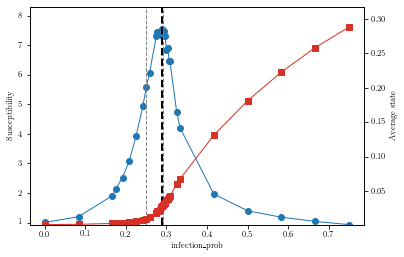

In [101]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "sis", "nbinom_cm")

config.graph.set_value("size", 500)
config.graph.edge_count.set_value("state", 1250)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 10000)
config.dynamics.set_value("recovery_prob", 0.5)
config.dynamics.set_value("auto_activation_prob", 0.001)
config.dynamics.set_value("num_active", 1)

# histories["sis"] = searchThresholds(config, "infection_prob", 0, 0.75, tol=0.01, numSamples=12, verbose=2)
showThresholdSearch(histories["sis"], f"infection_prob")

Scaning params [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Current diff: 0.1
Current history: {'thresholds': [0.5555555555555556], 'susceptibility': {0.0: [0.020404428861411767], 0.1111111111111111: [0.020608270215961802], 0.2222222222222222: [0.021514636497570808], 0.3333333333333333: [0.023249072678109755], 0.4444444444444444: [0.02768111271155435], 0.5555555555555556: [0.03757489213952701], 0.6666666666666666: [0.015611963410572846], 0.7777777777777777: [0.0068581824384734945], 0.8888888888888888: [0.0048218933012405185], 1.0: [0.0037323834607932674]}, 'averages': {0.0: [0.03573816666666666], 0.1111111111111111: [0.035965000000000004], 0.2222222222222222: [0.03746973333333334], 0.3333333333333333: [0.040909666666666664], 0.4444444444444444: [0.049258066666666676], 0.5555555555555556: [0.08956976666666668], 0.6666666666666666: [0.2296599666666667], 0.7777777777777777: [0.3306942], 0.8888888888888888: [0.400609966666

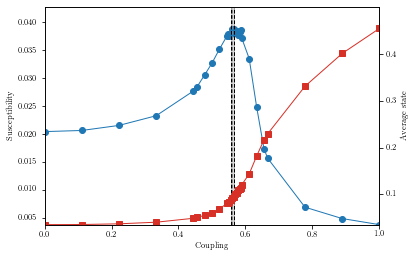

In [62]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "ising", "nbinom_cm")

config.graph.set_value("size", 500)
config.graph.edge_count.set_value("state", 1250)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 10000)

histories["ising"] = searchThresholds(config, "coupling", 0, 1, delta=1, tol=0.001, numSamples=48, verbose=2)

showThresholdSearch(histories["ising"], f"Coupling")


Scanning params: [1.         1.22222222 1.44444444 1.66666667 1.88888889 2.11111111
 2.33333333 2.55555556 2.77777778 3.        ]
Current diff: 0.2
[0.001404, 0.001444, 0.00133, 0.001323, 0.001494, 0.001432, 0.001526, 0.001465, 0.001557, 0.00145, 0.001489, 0.001595, 0.001427, 0.001471, 0.001472, 0.001386, 0.001467, 0.001507, 0.001527, 0.001508, 0.001298, 0.001411, 0.001568, 0.001502, 0.001384, 0.001539, 0.001348, 0.001496, 0.001436, 0.001577, 0.001391, 0.001439, 0.001438, 0.001429, 0.001508, 0.001475, 0.00141, 0.001354, 0.001578, 0.001514, 0.001484, 0.001474, 0.001514, 0.001484, 0.001622, 0.001393, 0.001475, 0.001563] 0.04978574756994205
[0.002757, 0.003229, 0.002492, 0.002612, 0.002086, 0.002211, 0.00246, 0.00208, 0.003184, 0.002446, 0.002392, 0.00255, 0.001932, 0.002071, 0.002196, 0.002598, 0.002195, 0.002067, 0.001785, 0.002427, 0.002582, 0.002038, 0.002253, 0.002028, 0.002148, 0.002391, 0.002181, 0.001986, 0.002175, 0.002227, 0.002422, 0.002171, 0.002067, 0.002276, 0.002109, 0.0019

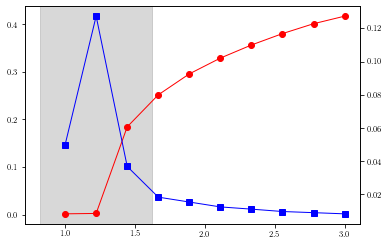

Current history: {'thresholds': [1.2222222222222223], 'susceptibility': {1.0: [0.04978574756994205], 1.2222222222222223: [0.1273307180641659], 1.4444444444444444: [0.03678628470529196], 1.6666666666666665: [0.018282553493837034], 1.8888888888888888: [0.015338386944893275], 2.111111111111111: [0.012394741125840015], 2.333333333333333: [0.011054885082303909], 2.5555555555555554: [0.00962258308767879], 2.7777777777777777: [0.00892786548187993], 3.0: [0.00822489732728599]}, 'averages': {1.0: [0.0014662083333333333], 1.2222222222222223: [0.002299166666666667], 1.4444444444444444: [0.18425206223030854], 1.6666666666666665: [0.2515165798814461], 1.8888888888888888: [0.29560527453804825], 2.111111111111111: [0.3288022386338338], 2.333333333333333: [0.3563075796694359], 2.5555555555555554: [0.3802901582199243], 2.7777777777777777: [0.4010119580724371], 3.0: [0.41691798816671466]}}
Scanning params: [0.82222222 0.91111111 1.         1.08888889 1.17777778 1.26666667
 1.35555556 1.44444444 1.533333

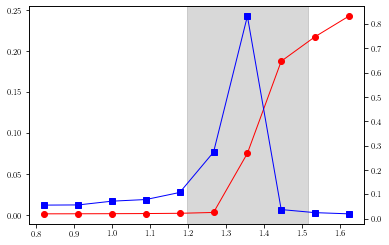

Current history: {'thresholds': [1.2222222222222223, 1.3555555555555556], 'susceptibility': {1.0: [0.04978574756994205, 0.07221344131025671], 1.2222222222222223: [0.1273307180641659], 1.4444444444444444: [0.03678628470529196, 0.03774442912680783], 1.6666666666666665: [0.018282553493837034], 1.8888888888888888: [0.015338386944893275], 2.111111111111111: [0.012394741125840015], 2.333333333333333: [0.011054885082303909], 2.5555555555555554: [0.00962258308767879], 2.7777777777777777: [0.00892786548187993], 3.0: [0.00822489732728599], 0.8222222222222223: [0.05602042242099768], 0.9111111111111112: [0.05680402078614186], 1.088888888888889: [0.078955677012763], 1.1777777777777778: [0.10791516742936928], 1.2666666666666666: [0.2734660125014858], 1.3555555555555556: [0.8313183449177395], 1.5333333333333332: [0.02513317119665321], 1.6222222222222222: [0.020242545786145393]}, 'averages': {1.0: [0.0014662083333333333, 0.0014895625000000002], 1.2222222222222223: [0.002299166666666667], 1.44444444444

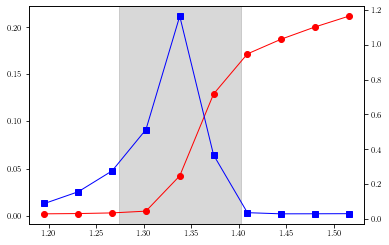

Current history: {'thresholds': [1.2222222222222223, 1.3555555555555556, 1.3377777777777777], 'susceptibility': {1.0: [0.04978574756994205, 0.07221344131025671], 1.2222222222222223: [0.1273307180641659], 1.4444444444444444: [0.03678628470529196, 0.03774442912680783, 0.027140065142130795], 1.6666666666666665: [0.018282553493837034], 1.8888888888888888: [0.015338386944893275], 2.111111111111111: [0.012394741125840015], 2.333333333333333: [0.011054885082303909], 2.5555555555555554: [0.00962258308767879], 2.7777777777777777: [0.00892786548187993], 3.0: [0.00822489732728599], 0.8222222222222223: [0.05602042242099768], 0.9111111111111112: [0.05680402078614186], 1.088888888888889: [0.078955677012763], 1.1777777777777778: [0.10791516742936928], 1.2666666666666666: [0.2734660125014858], 1.3555555555555556: [0.8313183449177395], 1.5333333333333332: [0.02513317119665321], 1.6222222222222222: [0.020242545786145393], 1.1955555555555557: [0.08665408203926898], 1.2311111111111113: [0.1542778205290438

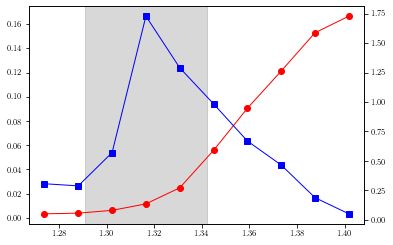

Current history: {'thresholds': [1.2222222222222223, 1.3555555555555556, 1.3377777777777777, 1.3164444444444443], 'susceptibility': {1.0: [0.04978574756994205, 0.07221344131025671], 1.2222222222222223: [0.1273307180641659], 1.4444444444444444: [0.03678628470529196, 0.03774442912680783, 0.027140065142130795], 1.6666666666666665: [0.018282553493837034], 1.8888888888888888: [0.015338386944893275], 2.111111111111111: [0.012394741125840015], 2.333333333333333: [0.011054885082303909], 2.5555555555555554: [0.00962258308767879], 2.7777777777777777: [0.00892786548187993], 3.0: [0.00822489732728599], 0.8222222222222223: [0.05602042242099768], 0.9111111111111112: [0.05680402078614186], 1.088888888888889: [0.078955677012763], 1.1777777777777778: [0.10791516742936928], 1.2666666666666666: [0.2734660125014858], 1.3555555555555556: [0.8313183449177395], 1.5333333333333332: [0.02513317119665321], 1.6222222222222222: [0.020242545786145393], 1.1955555555555557: [0.08665408203926898], 1.2311111111111113:

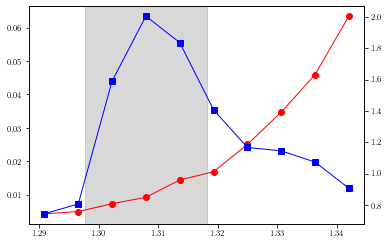

Current history: {'thresholds': [1.2222222222222223, 1.3555555555555556, 1.3377777777777777, 1.3164444444444443, 1.307911111111111], 'susceptibility': {1.0: [0.04978574756994205, 0.07221344131025671], 1.2222222222222223: [0.1273307180641659], 1.4444444444444444: [0.03678628470529196, 0.03774442912680783, 0.027140065142130795], 1.6666666666666665: [0.018282553493837034], 1.8888888888888888: [0.015338386944893275], 2.111111111111111: [0.012394741125840015], 2.333333333333333: [0.011054885082303909], 2.5555555555555554: [0.00962258308767879], 2.7777777777777777: [0.00892786548187993], 3.0: [0.00822489732728599], 0.8222222222222223: [0.05602042242099768], 0.9111111111111112: [0.05680402078614186], 1.088888888888889: [0.078955677012763], 1.1777777777777778: [0.10791516742936928], 1.2666666666666666: [0.2734660125014858], 1.3555555555555556: [0.8313183449177395], 1.5333333333333332: [0.02513317119665321], 1.6222222222222222: [0.020242545786145393], 1.1955555555555557: [0.08665408203926898], 

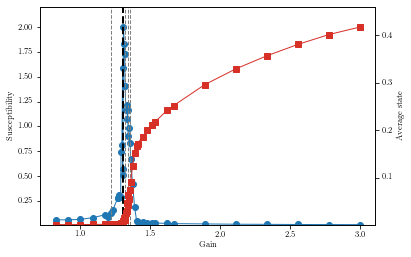

In [121]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "cowan_backward", "nbinom_cm")

N = 500
avgk = 5
config.graph.set_value("size", N)
config.graph.edge_count.set_value("state", avgk * N / 2)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 2000)
    
histories["cowan_backward"] = searchCowanThresholds(config, 1, 3, delta=2, tol=0.01, numSamples=48, numPoints=10, verbose=1)
showThresholdSearch(histories["cowan_backward"], f"Gain")


Scanning params: [1.         1.22222222 1.44444444 1.66666667 1.88888889 2.11111111
 2.33333333 2.55555556 2.77777778 3.        ]
Current diff: 0.2
1.0 0.04160798596778281 0.0006910208333333333
1.2222222222222223 0.041739987802074434 0.0006956458333333333
1.4444444444444444 0.04041604546582597 0.0006968125000000001
1.6666666666666665 4.005825414293118 0.0038724166666666664
1.8888888888888888 1.498075823678782 0.06677161458333335
2.111111111111111 0.5179065841168904 0.20586478125
2.333333333333333 0.13025174794132244 0.32467612500000004
2.5555555555555554 0.028630081410156615 0.36996158333333334
2.7777777777777777 0.01669422630336781 0.3947606666666667
3.0 0.013519441503554714 0.41295321875


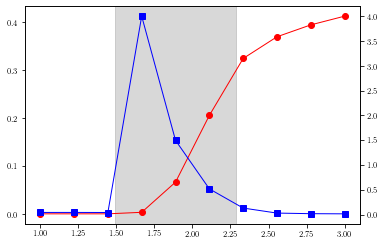

Current history: {'thresholds': [1.8888888888888888], 'susceptibility': {1.0: [0.04160798596778281], 1.2222222222222223: [0.041739987802074434], 1.4444444444444444: [0.04041604546582597], 1.6666666666666665: [4.005825414293118], 1.8888888888888888: [1.498075823678782], 2.111111111111111: [0.5179065841168904], 2.333333333333333: [0.13025174794132244], 2.5555555555555554: [0.028630081410156615], 2.7777777777777777: [0.01669422630336781], 3.0: [0.013519441503554714]}, 'averages': {1.0: [0.0006910208333333333], 1.2222222222222223: [0.0006956458333333333], 1.4444444444444444: [0.0006968125000000001], 1.6666666666666665: [0.0038724166666666664], 1.8888888888888888: [0.06677161458333335], 2.111111111111111: [0.20586478125], 2.333333333333333: [0.32467612500000004], 2.5555555555555554: [0.36996158333333334], 2.7777777777777777: [0.3947606666666667], 3.0: [0.41295321875]}}
Scanning params: [1.48888889 1.57777778 1.66666667 1.75555556 1.84444444 1.93333333
 2.02222222 2.11111111 2.2        2.288

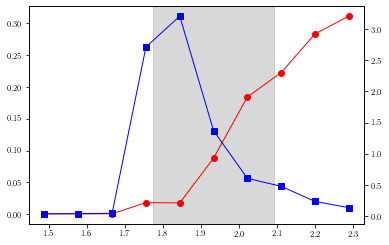

Current history: {'thresholds': [1.8888888888888888, 1.9333333333333331], 'susceptibility': {1.0: [0.04160798596778281], 1.2222222222222223: [0.041739987802074434], 1.4444444444444444: [0.04041604546582597], 1.6666666666666665: [4.005825414293118], 1.8888888888888888: [1.498075823678782], 2.111111111111111: [0.5179065841168904], 2.333333333333333: [0.13025174794132244], 2.5555555555555554: [0.028630081410156615], 2.7777777777777777: [0.01669422630336781], 3.0: [0.013519441503554714], 1.488888888888889: [0.04232538999523525], 1.5777777777777777: [0.044673653370402085], 1.6666666666666667: [0.05148945295144955], 1.7555555555555555: [2.7088759011457624], 1.8444444444444443: [3.202993887691987], 1.9333333333333331: [1.3711251860135136], 2.022222222222222: [0.6098005138986935], 2.1111111111111107: [0.4818135629863094], 2.1999999999999997: [0.24048265410189704], 2.2888888888888888: [0.14095219558030017]}, 'averages': {1.0: [0.0006910208333333333], 1.2222222222222223: [0.0006956458333333333],

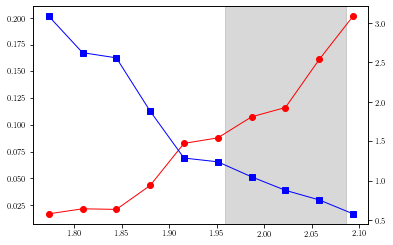

Current history: {'thresholds': [1.8888888888888888, 1.9333333333333331, 2.022222222222222], 'susceptibility': {1.0: [0.04160798596778281], 1.2222222222222223: [0.041739987802074434], 1.4444444444444444: [0.04041604546582597], 1.6666666666666665: [4.005825414293118], 1.8888888888888888: [1.498075823678782], 2.111111111111111: [0.5179065841168904], 2.333333333333333: [0.13025174794132244], 2.5555555555555554: [0.028630081410156615], 2.7777777777777777: [0.01669422630336781], 3.0: [0.013519441503554714], 1.488888888888889: [0.04232538999523525], 1.5777777777777777: [0.044673653370402085], 1.6666666666666667: [0.05148945295144955], 1.7555555555555555: [2.7088759011457624], 1.8444444444444443: [3.202993887691987, 2.5584441047946997], 1.9333333333333331: [1.3711251860135136], 2.022222222222222: [0.6098005138986935, 0.8801781996092218], 2.1111111111111107: [0.4818135629863094], 2.1999999999999997: [0.24048265410189704], 2.2888888888888888: [0.14095219558030017], 1.7733333333333332: [3.086470

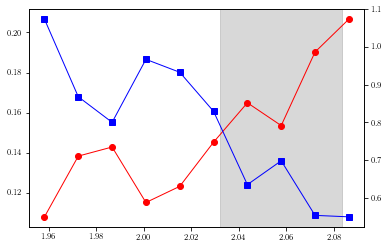

Current history: {'thresholds': [1.8888888888888888, 1.9333333333333331, 2.022222222222222, 2.057777777777778], 'susceptibility': {1.0: [0.04160798596778281], 1.2222222222222223: [0.041739987802074434], 1.4444444444444444: [0.04041604546582597], 1.6666666666666665: [4.005825414293118], 1.8888888888888888: [1.498075823678782], 2.111111111111111: [0.5179065841168904], 2.333333333333333: [0.13025174794132244], 2.5555555555555554: [0.028630081410156615], 2.7777777777777777: [0.01669422630336781], 3.0: [0.013519441503554714], 1.488888888888889: [0.04232538999523525], 1.5777777777777777: [0.044673653370402085], 1.6666666666666667: [0.05148945295144955], 1.7555555555555555: [2.7088759011457624], 1.8444444444444443: [3.202993887691987, 2.5584441047946997], 1.9333333333333331: [1.3711251860135136], 2.022222222222222: [0.6098005138986935, 0.8801781996092218], 2.1111111111111107: [0.4818135629863094], 2.1999999999999997: [0.24048265410189704], 2.2888888888888888: [0.14095219558030017], 1.77333333

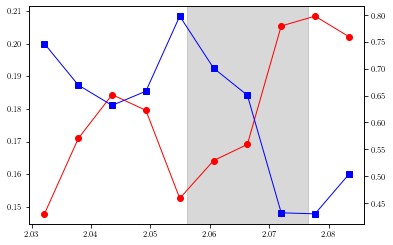

Current history: {'thresholds': [1.8888888888888888, 1.9333333333333331, 2.022222222222222, 2.057777777777778, 2.066311111111111], 'susceptibility': {1.0: [0.04160798596778281], 1.2222222222222223: [0.041739987802074434], 1.4444444444444444: [0.04041604546582597], 1.6666666666666665: [4.005825414293118], 1.8888888888888888: [1.498075823678782], 2.111111111111111: [0.5179065841168904], 2.333333333333333: [0.13025174794132244], 2.5555555555555554: [0.028630081410156615], 2.7777777777777777: [0.01669422630336781], 3.0: [0.013519441503554714], 1.488888888888889: [0.04232538999523525], 1.5777777777777777: [0.044673653370402085], 1.6666666666666667: [0.05148945295144955], 1.7555555555555555: [2.7088759011457624], 1.8444444444444443: [3.202993887691987, 2.5584441047946997], 1.9333333333333331: [1.3711251860135136], 2.022222222222222: [0.6098005138986935, 0.8801781996092218], 2.1111111111111107: [0.4818135629863094], 2.1999999999999997: [0.24048265410189704], 2.2888888888888888: [0.14095219558

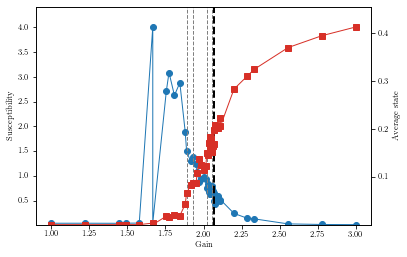

In [26]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "cowan_forward", "nbinom_cm")

N = 500
avgk = 5
config.graph.set_value("size", N)
config.graph.edge_count.set_value("state", avgk * N / 2)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 4000)
config.dynamics.set_value("num_active", 1)
    
histories["cowan_forward"] = searchCowanThresholds(config, 1, 3, delta=2, tol=0.01, numSamples=48, numPoints=10, verbose=1)
showThresholdSearch(histories["cowan_forward"], f"Gain")



In [33]:
import json

with open("thresholds.json", "w") as f:
    json.dump(histories, f )
    

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.45555556
 0.47777778 0.5        0.52222222 0.54444444 0.54666667 0.55111111
 0.55555556 0.56       0.56444444 0.56666667 0.56888889 0.57333333
 0.57777778 0.58222222 0.58666667 0.58888889 0.61111111 0.63333333
 0.65555556 0.66666667 0.77777778 0.88888889 1.        ]
[0.         0.08333333 0.16666667 0.175      0.19166667 0.20833333
 0.225      0.24166667 0.25       0.25833333 0.275      0.27666667
 0.28       0.28333333 0.28666667 0.29       0.29166667 0.29333333
 0.29666667 0.3        0.30333333 0.30666667 0.30833333 0.325
 0.33333333 0.41666667 0.5        0.58333333 0.66666667 0.75      ]
[0.82222222 0.91111111 1.         1.08888889 1.17777778 1.19555556
 1.22222222 1.23111111 1.26666667 1.26666667 1.27377778 1.288
 1.29084444 1.29653333 1.30222222 1.30222222 1.30222222 1.30791111
 1.3136     1.31644444 1.31928889 1.32497778 1.33066667 1.33635556
 1.33777778 1.34204444 1.34488889 1.35555556 1.35911111 1.37333333
 1.38755556 1.

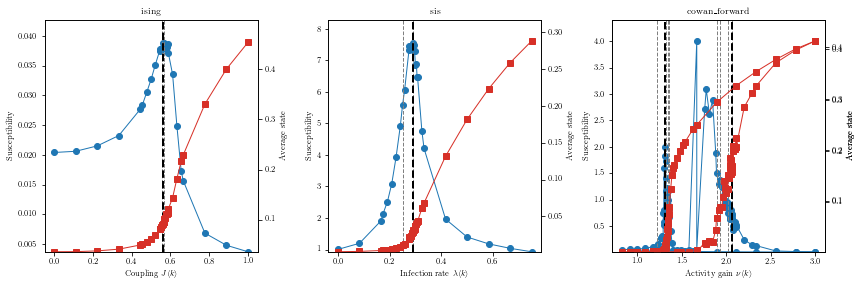

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

xlabels = {
    "ising": r"Coupling $J\langle k \rangle$",
    "sis": r"Infection rate $\lambda \langle k \rangle$",
    "cowan_backward": r"Activity gain $\nu\langle k \rangle$",
    "cowan_forward": r"Activity gain $\nu\langle k \rangle$"
}

for i, k in enumerate(xlabels.keys()):
    if k[:5] == "cowan":
        i = 2
    plotThresholdSearch(ax[i], histories[k], xlabels[k])
    ax[i].set_title(k)
    x = list(histories[k].keys())
#     ax[i].set_xlim([min(x), max(x)])

fig.tight_layout()
plt.show()